# MFC dataset analysis


In [1]:
import os

os.listdir(os.getcwd())

['axis-mft.ipynb',
 'axis-new.ipynb',
 'axis.ipynb',
 'finetune-bert.ipynb',
 'frameaxis-prepare-multi.ipynb',
 'frameaxis-prepare.ipynb',
 'friss-base.ipynb',
 'friss-dict-extract.ipynb',
 'friss-frameaxis-dict-extract.ipynb',
 'friss-frameaxis-v2.ipynb',
 'friss-frameaxis.ipynb',
 'mfc-analysis.ipynb',
 'mlm.ipynb',
 'test.ipynb']

In [2]:
immigration_path = "../../data/mfc/immigration_labeled.json"
deathpenalty_path = "../../data/mfc/deathpenalty_labeled.json"
guncontrol_path = "../../data/mfc/guncontrol_labeled.json"
samesex_path = "../../data/mfc/samesex_labeled.json"
tobacco_path = "../../data/mfc/tobacco_labeled.json"
frames_code = "../../data/mfc/codes.json"

In [3]:
# read unlabeled data
import json

# read labeled data
with open(immigration_path) as f:
    immigration = json.load(f)

with open(deathpenalty_path) as f:
    deathpenalty = json.load(f)

with open(guncontrol_path) as f:
    guncontrol = json.load(f)

with open(samesex_path) as f:
    samesex = json.load(f)

with open(tobacco_path) as f:
    tobacco = json.load(f)

# read frames
with open(frames_code) as f:
    codes = json.load(f)

In [111]:
def get_frame_name(code):
    if "." not in str(code):
        return codes[str(code) + ".2"]
    return codes[code]

def get_tone_name(code):
    if code == "17":
        return "Pro"
    elif code == "18":
        return "Neutral"
    elif code == "19":
        return "Anti"
    else:
        return codes[code]


In [112]:
# generate statistics count
print("immigration data count: ", len(immigration))
print("deathpenalty data count: ", len(deathpenalty))
print("guncontrol data count: ", len(guncontrol))
print("samesex data count: ", len(samesex))
print("tobacco data count: ", len(tobacco))

immigration data count:  6757
deathpenalty data count:  6398
guncontrol data count:  6689
samesex data count:  10583
tobacco data count:  5274


In [100]:
def process_json(json_path, method="full_text"):
    # Load the JSON file
    with open(json_path) as f:
        labeled = json.load(f)

    frames = []
    stats = {
        "total_processed": 0,
        "multiple_primary_frames": 0,
        "no_tone": 0,
        "no_frame": 0,
        "error_articles_multiple_frames": [],
        "error_articles_no_tone": [],
        "error_articles_no_frame": [],
    }

    # Loop through labeled data
    for idx, article in labeled.items():
        current_article = {}
        multiple_primary_frames_detected = False

        # Check for each annotator in the 'framing' section
        for annotator, annotations in article["annotations"]["framing"].items():
            # Check if the annotator marked the segment as irrelevant
            if article["annotations"]["irrelevant"].get(annotator, False):
                continue  # Skip this annotator if marked as irrelevant

            for annotation in annotations:
                frame = str(annotation["code"])
                start = annotation["start"]
                end = annotation["end"]

                # Detect if primary frame if .2 is in the code
                if ".2" in frame:
                    if current_article.get("frame", False):
                        if current_article["frame"] != frame:
                            if (
                                not multiple_primary_frames_detected
                            ):  # Only count once per article
                                stats["multiple_primary_frames"] += 1
                                stats["error_articles_multiple_frames"].append(idx)
                                multiple_primary_frames_detected = True
                            print("Multiple primary frames detected for article", idx)
                            continue

                    current_article["frame"] = frame

                if method == "span_restricted":
                    # if current frame is the same as frame in current_article extract the text using start and end
                    if current_article.get("frame", False):
                        primary_frame = str(current_article["frame"]).split(".")[0]
                        current_frame = str(frame).split(".")[0]

                        if primary_frame == current_frame:
                            if current_article.get("text", False):
                                current_article["text"] += " " + article["text"][start:end]
                            else:
                                current_article["text"] = article["text"][start:end]

        for annotator, tone in article["annotations"]["tone"].items():
            for annotation in tone:
                current_article["tone"] = annotation["code"]

        if method == "full_text":
            current_article["text"] = article["text"].replace("\n", " ")

        # If no tone, skip with print
        if not current_article.get("tone", False):
            print("No tone detected for article", idx)
            stats["no_tone"] += 1
            stats["error_articles_no_tone"].append(idx)
            continue

        if not current_article.get("frame", False):
            print("No frame detected for article", idx)
            stats["no_frame"] += 1
            stats["error_articles_no_frame"].append(idx)
            continue

        # Add the article to the frames list if processed correctly
        frames.append(current_article)
        stats["total_processed"] += 1

    # Return both processed frames and statistics
    return {"frames": frames, "stats": stats}

In [101]:
def process_json_with_tone(json_path):
    frames = {}

    # Load the JSON file
    with open(json_path) as f:
        labeled = json.load(f)
    
    # Loop through labeled data
    for idx, article in labeled.items():
        # Check for each annotator in the 'framing' section
        for annotator, annotations in article['annotations']['framing'].items():
            # Check if the annotator marked the segment as irrelevant
            if article['annotations']['irrelevant'].get(annotator, False):
                continue  # Skip this annotator if marked as irrelevant

            for annotation in annotations:
                # Extract the text corresponding to the annotation
                frame_text = article['text'][annotation['start']:annotation['end']]

                # Replace \n and other 
                frame_text = frame_text.replace("\n", " ").replace("\t", " ").replace("\r", " ")

                # make lower case
                frame_text = frame_text.lower()

                tone = article["primary_tone"]

                code_edited = int(str(annotation['code']).split(".")[0])

                if frames.get(code_edited, False):
                    if frames[code_edited].get(tone, False):
                        frames[code_edited][tone].append(frame_text)
                    else:
                        frames[code_edited][tone] = [frame_text]
                else:
                    frames[code_edited] = {
                        tone: [frame_text]
                    }
    
    return frames


# Call the function for each JSON object
immigration_frames = process_json_with_tone(immigration_path)

deathpenalty_frames = process_json_with_tone(deathpenalty_path)

guncontrol_frames = process_json_with_tone(
    guncontrol_path,
)

samesex_frames = process_json_with_tone(
    samesex_path,
)

tobacco_frames = process_json_with_tone(
    tobacco_path,
)

In [99]:
def refactor_dict(frames):
    refactored_dict = {}

    for article in frames["frames"]:
        if sorted(["frame", "text", "tone"]) != sorted(list(article.keys())):
            print("Error: article has missing keys", article.keys())
            continue

        frame = article["frame"]
        tone_prefix = str(
            int(article["tone"])
        )  # Convert tone to integer and then to string to get the prefix
        text = article["text"]

        # Initialize the frame dictionary if not already present
        if frame not in refactored_dict:
            refactored_dict[frame] = {}

        # Initialize the tone list if not already present
        if tone_prefix not in refactored_dict[frame]:
            refactored_dict[frame][tone_prefix] = []

        # Append the text to the appropriate list
        refactored_dict[frame][tone_prefix].append(text)

    # The refactored_dict now contains the structure you described
    return refactored_dict


refactored_imm = refactor_dict(immigration_frames)

refactored_dp = refactor_dict(deathpenalty_frames)

refactored_gc = refactor_dict(guncontrol_frames)

refactored_ss = refactor_dict(samesex_frames)

refactored_tb = refactor_dict(tobacco_frames)

KeyError: 'frames'

In [50]:
# count the number of articles in each frame and tone
def count_articles(refactored_dict):
    total_articles = 0
    for frame, tones in refactored_dict.items():
        for tone, articles in tones.items():
            total_articles += len(articles)
    return total_articles


assert count_articles(refactored_imm) == immigration_frames["stats"]["total_processed"]
assert count_articles(refactored_dp) == deathpenalty_frames["stats"]["total_processed"]
assert count_articles(refactored_gc) == guncontrol_frames["stats"]["total_processed"]
assert count_articles(refactored_ss) == samesex_frames["stats"]["total_processed"]
assert count_articles(refactored_tb) == tobacco_frames["stats"]["total_processed"]

In [62]:
# combine all the refactored dicts into a single one
combined_ref = {}

for refactored_dict, name in zip(
    [refactored_imm, refactored_dp, refactored_gc, refactored_ss, refactored_tb],
    ["immigration", "deathpenalty", "guncontrol", "samesex", "tobacco"],
):
    for frame, tones in refactored_dict.items():
        if frame not in combined_ref:
            combined_ref[frame] = {}
        for tone, articles in tones.items():
            if tone not in combined_ref[frame]:
                combined_ref[frame][tone] = []
            combined_ref[frame][tone] += articles

len(combined_ref["10.2"]["17"])

710

# Extract the adjectives, adverbs, nouns and verbs from each text sequence


In [19]:
!pip install spacy
!python -m spacy download en_core_web_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [20]:
import spacy

# Load the spaCy English language model
nlp = spacy.load("en_core_web_sm")

doc = nlp("The war was harming the economy successfully.")
for token in doc:
    print(token.text, token.pos_, token.lemma_)

The DET the
war NOUN war
was AUX be
harming VERB harm
the DET the
economy NOUN economy
successfully ADV successfully
. PUNCT .


In [102]:
import spacy

# Load the spaCy English language model
nlp = spacy.load("en_core_web_sm")

# Assuming 'frames' is your existing dictionary with text sequences
frame_words = {}

# pos_filter
pos_filter = ["ADJ", "NOUN", "VERB", "ADV"]

counter = 0
for code, tone in immigration_frames.items():
    print("Processing frame", code, "(", counter + 1, "of", len(immigration_frames), ")")
    for t in tone:
        words_list = []
        for text in immigration_frames[code][t]:
            # Process the text using spaCy
            doc = nlp(text)
            # Extract adjectives
            for token in doc:
                if token.pos_ == "ADJ" and "ADJ" in pos_filter:
                    words_list.append(
                        {"word": token.lemma_, "pos": "ADJ", "text": text}
                    )
                elif token.pos_ == "NOUN" and "NOUN" in pos_filter:
                    words_list.append(
                        {"word": token.lemma_, "pos": "NOUN", "text": text}
                    )
                elif token.pos_ == "VERB" and "VERB" in pos_filter:
                    words_list.append(
                        {"word": token.lemma_, "pos": "VERB", "text": text}
                    )
                elif token.pos_ == "ADV" and "ADV" in pos_filter:
                    words_list.append(
                        {"word": token.lemma_, "pos": "ADV", "text": text}
                    )

        if code not in frame_words:
            frame_words[code] = {}

        frame_words[code][t] = words_list

    counter += 1

Processing frame 10 ( 1 of 15 )
Processing frame 11 ( 2 of 15 )
Processing frame 5 ( 3 of 15 )
Processing frame 15 ( 4 of 15 )
Processing frame 13 ( 5 of 15 )
Processing frame 3 ( 6 of 15 )
Processing frame 12 ( 7 of 15 )
Processing frame 2 ( 8 of 15 )
Processing frame 1 ( 9 of 15 )
Processing frame 7 ( 10 of 15 )
Processing frame 6 ( 11 of 15 )
Processing frame 9 ( 12 of 15 )
Processing frame 4 ( 13 of 15 )
Processing frame 8 ( 14 of 15 )
Processing frame 14 ( 15 of 15 )


In [103]:
combined_frame_words = {}

# combine tones 
for frame, tones in frame_words.items():
    for tone, words in tones.items():
        combined_frame_words[frame] = words

# Create for each frame a cloud of words using tf-idf

In [120]:
from collections import Counter
import math

# Helper function to calculate TF for a single document
def calculate_tf(document):
    tf_dict = {}
    total_terms = len(document)
    term_counts = Counter(document)
    for term, count in term_counts.items():
        tf_dict[term] = count / total_terms
    return tf_dict

# Calculate DF for all documents
def calculate_df(documents):
    df_dict = Counter()
    for document in documents:
        df_dict.update(set(document))
    return df_dict

# Calculate TF, DF, IDF, and TF-IDF for the collection
def calculate_tf_idf(doc_dict, smoothed=False):
     # Extract documents and their identifiers
    documents = [[word_dict["word"] for word_dict in word_dicts] for word_dicts in doc_dict.values()]
    frame_codes = list(doc_dict.keys())

    # Calculate TF for each document
    tfs = {frame_code: calculate_tf(document) for document, frame_code in zip(documents, frame_codes)}
    
    # Calculate DF for the entire collection
    df = calculate_df(documents)
    N = len(documents)

    print("Found N =", N, "documents")
    # print df vocab size
    print("Vocab size =", len(df))
    
    # Calculate IDF
    if smoothed:
        idf = {term: math.log((N + 1) / (frequency + 1)) + 1 for term, frequency in df.items()}
    else:
        idf = {term: (math.log(N / frequency) + 0) for term, frequency in df.items()} 
    
    # Calculate TF-IDF for each document and include document identifiers
    tf_idf = {frame_code: {term: tf_value * idf[term] for term, tf_value in tfs[frame_code].items()} for frame_code in frame_codes}
    
    return tfs, df, idf, tf_idf

In [121]:
# Calculate TF-IDF without using Pandas
tfs, df, idf, tf_idf = calculate_tf_idf(combined_frame_words, False)

Found N = 15 documents
Vocab size = 9411


In [122]:
# top 10 words for each frame
top_words = {}

for frame, words in tf_idf.items():
    print("Top words for frame:", get_frame_name(frame))
    
    # Sort the words by their TF-IDF value
    sorted_words = sorted(words.items(), key=lambda x: x[1], reverse=True)

    # Print the top 10 words
    top_words[frame] = sorted_words[:10]

    for word, score in sorted_words[:10]:
        print(word, score, end=", ")

    print("\n")


Top words for frame: Quality of Life primary
greek 0.0023856376548679562, interpreter 0.0019518853539828732, retailer 0.0017350092035403318, tate 0.0016290820810205618, welfare 0.0015143732277121407, dreamer 0.001480410037283533, reunion 0.0013575684008504682, parent 0.001253826687658696, elderly 0.0012467714431850475, english 0.0012324054203695946, 

Top words for frame: Cultural Identity primary
black 0.0022946640009762756, hispanic 0.0020077183280198824, bureau 0.001695962280075557, population 0.0016406934772169733, pew 0.0015513221415050878, percent 0.0015156181897161278, demographer 0.001406706658682761, census 0.0013657034671378672, yoga 0.0012431278275839164, assimilation 0.00124121175766126, 

Top words for frame: Legality, Constitutionality, Jurisdiction primary
court 0.00334110766551075, judge 0.00264832606385572, circuit 0.0019695852576416036, 11th 0.0014291833297757847, ruling 0.0013468510669183407, lawsuit 0.0013301216707455694, amendment 0.0011936989352844855, card 0.0011

# Create for each frame+tone a cloud of words using tf-idf

In [132]:
from collections import Counter
import math

# Helper function to calculate TF for a single document
def calculate_tf(document):
    tf_dict = {}
    total_terms = len(document)
    term_counts = Counter(document)
    for term, count in term_counts.items():
        tf_dict[term] = count / total_terms
    return tf_dict

# Calculate DF for all documents
def calculate_df(documents):
    df_dict = Counter()
    for document in documents:
        df_dict.update(set(document))
    return df_dict

# Modified to calculate TF-IDF for documents organized by frame+tone
def calculate_tf_idf(doc_dict, smoothed=False):
    # Flatten the structure to a list of documents with frame+tone as their identifier
    documents = []
    identifiers = []
    for frame, tone_dicts in doc_dict.items():
        for tone, word_dicts in tone_dicts.items():
            if str(tone) in ["17", "19"]:
                document_words = [word_dict["word"] for word_dict in word_dicts]
                documents.append(document_words)
                identifiers.append(f"{frame}_{tone}")
    
    # Calculate TF for each document
    tfs = {identifier: calculate_tf(document) for document, identifier in zip(documents, identifiers)}
    
    # Calculate DF for the entire collection
    df = calculate_df(documents)
    N = len(documents)
    
    print("Found N =", N, "documents")
    # Print DF vocab size
    print("Vocab size =", len(df))
    
    # Calculate IDF
    if smoothed:
        idf = {term: math.log((N + 1) / (1 + frequency)) + 1 for term, frequency in df.items()}
    else:
        idf = {term: (math.log(N / frequency) + 0) for term, frequency in df.items()}  # Added 1 to avoid division by zero
    
    # Calculate TF-IDF for each document and include document identifiers
    tf_idf = {identifier: {term: (tf_value * idf[term]) for term, tf_value in tfs[identifier].items()} for identifier in identifiers}
    
    return tfs, df, idf, tf_idf

tfs, df, idf, tf_idf = calculate_tf_idf(frame_words, False)

Found N = 30 documents
Vocab size = 18324


In [147]:
# top 10 words for each frame
top_words = {}

for frame, words in tf_idf.items():
    f = get_frame_name(frame.split("_")[0])
    t = get_tone_name(frame.split("_")[1])

    print("Top words for frame:", f, "and tone:", t)
    
    # Sort the words by their TF-IDF value
    sorted_words = sorted(words.items(), key=lambda x: x[1], reverse=True)

    # Print the top 10 words
    top_words[frame] = sorted_words[:10]

    for word, score in sorted_words[:10]:
        print(word, f"{score:1.4f}", end=", ")

    print("\n")



Top words for frame: Quality of Life primary and tone: Pro
daughter 0.0006, stamp 0.0005, scholarship 0.0005, tuition 0.0005, mom 0.0005, food 0.0005, goat 0.0004, parent 0.0004, living 0.0004, mother 0.0004, 

Top words for frame: Quality of Life primary and tone: Anti
elboukili 0.0022, jitter 0.0018, ronnebeck 0.0018, schooling 0.0016, quality 0.0011, stamp 0.0010, welfare 0.0009, amerasian 0.0009, tiresome 0.0009, deaden 0.0009, 

Top words for frame: Cultural Identity primary and tone: Pro
exhibition 0.0010, pot 0.0009, culture 0.0009, statue 0.0009, music 0.0009, film 0.0007, african 0.0007, candy 0.0007, exhibit 0.0007, korean 0.0006, 

Top words for frame: Cultural Identity primary and tone: Anti
amerasian 0.0024, elapse 0.0021, culturalist 0.0018, tweet 0.0014, @foxandfriend 0.0014, o'reilly 0.0012, percent 0.0011, balkanize 0.0010, multi 0.0009, culture 0.0009, 

Top words for frame: Legality, Constitutionality, Jurisdiction primary and tone: Pro
judge 0.0012, lawsuit 0.0011, 

In [125]:
def calculate_tone_specific_tf_idf(frame, tf_idf, frame_words, tones_to_process, top_n=200):
    # Select the top N words with the highest original TF-IDF values for the specific frame
    top_n_words = [word for word, score in sorted(tf_idf[frame].items(), key=lambda item: item[1], reverse=True)[:top_n]]
    
    # Initialize counters for term frequency for each tone to process
    tf_counters = {str(tone): Counter() for tone in tones_to_process}
    
    # Initialize the dictionary to store recalculated TF-IDF values for each tone
    tone_tf_idf = {str(tone): {} for tone in tones_to_process}
    
    # Calculate the term frequency (TF) for each of the top N words within each specified tone category
    for tone_code in tones_to_process:
        tone_label = str(tone_code)
        tone_words = [word_info['word'] for word_info in frame_words[frame].get(tone_label, []) if word_info['word'] in top_n_words]
        tf_counters[tone_label].update(tone_words)
    
    # Document frequency (DF) is the number of tone categories in which the word appears
    df_counts = Counter()
    for word in top_n_words:
        for tone_label in tf_counters.keys():
            if tf_counters[tone_label][word] > 0:
                df_counts[word] += 1
    
    # Calculate the new TF-IDF values for each word for each specified tone category
    num_tones = len(tf_counters)
    for tone_label, tf_counter in tf_counters.items():
        for word in top_n_words:
            tf = tf_counter[word]
            df = df_counts[word] if df_counts[word] > 0 else 1  # To avoid division by zero
            idf = math.log(num_tones / df)
            tone_tf_idf[tone_label][word] = tf * idf
    
    # sort the tone_tf_idf
    for tone in tone_tf_idf:
        tone_tf_idf[tone] = {k: v for k, v in sorted(tone_tf_idf[tone].items(), key=lambda item: item[1], reverse=True)}

    return tone_tf_idf

In [35]:
tone_tf_idf = {}

for frame in combined_frame_words.keys():
    tone_tf_idf[frame] = calculate_tone_specific_tf_idf(frame, tf_idf, frame_words, ["17", "18", "19"])

# Visualize

In [36]:
# print the top 10 words for each frame and tone
for frame, tones in tone_tf_idf.items():
    print("Top 10 words for frame", get_frame_name(frame))
    for tone, words in tones.items():
        print("Tone", get_tone_name(tone), ":", list(words.keys())[:10])
    print()

Top 10 words for frame Quality of Life primary
Tone Pro : ['executive', 'much', 'past', 'middle', 'criminal', 'real', 'difficult', 'common', 'empty', 'close']
Tone Neutral : ['rapid', 'surprising', 'inevitable', 'dependent', 'eld', 'u.s.-born', 'drunk', 'urban', 'telltale', 'staggering']
Tone Anti : ['urban', 'u.s.-born', 'middle', 'telltale', 'indigent', 'worrisome', 'unkempt', 'activist', 'hungarian', 'socialized']

Top 10 words for frame Legality, Constitutionality, Jurisdiction primary
Tone Pro : ['equal', 'nicaraguan', 'irreparable', 'frequent', 'somali', 'draconian', 'polish', 'grand', 'supervisory', 'abusive']
Tone Neutral : ['malaysian', 'yearly', 'hefty', 'spousal', 'serbian', 'aged', 'express', 'simplistic', 'bosnian', 'incredible']
Tone Anti : ['committed', 'unsolicited', 'upsetting', 'peruvian', 'standardized', 'legal', 'constitutional', 'temporary', 'appellate', 'prosecutorial']

Top 10 words for frame Capacity and Resources primany
Tone Pro : ['available', 'bilingual', 'm

# Detect importance using pmi-freq


In [23]:
seed_words_dict = {
    "1.2": {"17": "prosperity", "18": "economic", "19": "recession"},
    "2.2": {"17": "abundant", "18": "resources", "19": "scarce"},
    "3.2": {"17": "ethical", "18": "morality", "19": "immoral"},
    "4.2": {"17": "equitable", "18": "equality", "19": "biased"},
    "5.2": {"17": "lawful", "18": "legality", "19": "illegal"},
    "6.2": {"17": "effective", "18": "policy", "19": "ineffective"},
    "7.2": {"17": "justice", "18": "crime", "19": "injustice"},
    "8.2": {"17": "secure", "18": "security", "19": "vulnerable"},
    "9.2": {"17": "healthy", "18": "health", "19": "hazardous"},
    "10.2": {"17": "thriving", "18": "lifestyle", "19": "poor"},
    "11.2": {"17": "rich", "18": "culture", "19": "eroded"},
    "12.2": {"17": "supportive", "18": "sentiment", "19": "dissatisfied"},
    "13.2": {"17": "stable", "18": "political", "19": "corrupt"},
    "14.2": {"17": "respected", "18": "regulation", "19": "sanctioned"},
    "15.2": {"17": "N/A", "18": "various", "19": "N/A"},
}

In [16]:
from collections import Counter

df_counts = Counter()

for frame, tones in frame_words.items():
    # Track words encountered in this frame to avoid counting them multiple times within the same frame
    for tone, word_data_list in tones.items():
        words_seen = set()
        for word_data in word_data_list:
            word = word_data["word"]
            # Add the word to the set if not already encountered in this frame
            if word not in words_seen:
                df_counts[word] += 1
                words_seen.add(word)

In [273]:
# calculate the tf using Counter
tf = {}

pos_filter = ["ADJ"]

for frame, tones in frame_words.items():
    for tone, word_data_list in tones.items():
        tf_counts = Counter()

        for word_data in word_data_list:
            word = word_data["word"]
            pos = word_data["pos"]
            if pos in pos_filter:
                tf_counts[word] += 1

        if frame not in tf:
            tf[frame] = {}

        tf[frame][tone] = tf_counts

In [275]:
# get most common n words for each frame and tone
n = 2

tone_dict = {
    "17": "Positive",
    "18": "Neutral",
    "19": "Negative",
}

top_words = {}

for frame, tones in tf.items():
    for tone, word_counts in tones.items():
        if codes[frame] not in top_words:
            top_words[codes[frame]] = {}
        top_words[codes[frame]][tone_dict[tone]] = word_counts.most_common(n)

top_words

{'Quality of Life primary': {'Positive': [('many', 176), ('new', 146)],
  'Neutral': [('many', 13), ('migrant', 13)],
  'Negative': [('illegal', 9), ('other', 9)]},
 'Legality, Constitutionality, Jurisdiction primary': {'Negative': [('federal',
    301),
   ('illegal', 267)],
  'Positive': [('federal', 527), ('legal', 459)],
  'Neutral': [('federal', 182), ('legal', 135)]},
 'Capacity and Resources primany': {'Negative': [('illegal', 40),
   ('federal', 25)],
  'Positive': [('more', 70), ('last', 47)],
  'Neutral': [('last', 22), ('more', 22)]},
 'Cultural Identity primary': {'Negative': [('illegal', 67), ('american', 65)],
  'Positive': [('american', 244), ('new', 227)],
  'Neutral': [('illegal', 117), ('new', 93)]},
 'Health and Safety primary': {'Positive': [('medical', 98), ('illegal', 96)],
  'Negative': [('illegal', 34), ('federal', 17)],
  'Neutral': [('illegal', 10), ('public', 10)]},
 'Security and Defense primary': {'Positive': [('national', 18),
   ('terrorist', 15)],
  'Neu

In [276]:
# calculate the idf using df_counts

import math

idf = {}

for w in df_counts:
    idf[w] = math.log(len(refactored_imm) * 3 / df_counts[w])

In [277]:
# calculate the tf-idf
tf_idf = {}

for frame, tones in tf.items():
    for tone, word_counts in tones.items():
        if frame not in tf_idf:
            tf_idf[frame] = {}
        if tone not in tf_idf[frame]:
            tf_idf[frame][tone] = {}
        for word, count in word_counts.items():
            tf_idf[frame][tone][word] = count * idf[word]

In [278]:
# sort tf-idf
sorted_tf_idf = {}

for frame, tones in tf_idf.items():
    for tone, word_counts in tones.items():
        if frame not in sorted_tf_idf:
            sorted_tf_idf[frame] = {}
        if tone not in sorted_tf_idf[frame]:
            sorted_tf_idf[frame][tone] = sorted(
                word_counts.items(), key=lambda x: x[1], reverse=True
            )

In [279]:
# print top 2 tf-idf words for each frame and tone

top_tfidf_words = {}

for frame, tones in sorted_tf_idf.items():
    for tone, word_counts in tones.items():
        if codes[frame] not in top_tfidf_words:
            top_tfidf_words[codes[frame]] = {}
        top_tfidf_words[codes[frame]][tone_dict[tone]] = word_counts[:n]

top_tfidf_words

{'Quality of Life primary': {'Positive': [('elderly', 35.028154804651834),
   ('afraid', 27.91999172332454)],
  'Neutral': [('wiry', 11.419987469310959), ('humiliated', 7.613324979540639)],
  'Negative': [('socialized', 7.613324979540639),
   ('scared', 5.41610040220442)]},
 'Legality, Constitutionality, Jurisdiction primary': {'Negative': [('unconstitutional',
    45.06426154815481),
   ('constitutional', 40.86618060542714)],
  'Positive': [('legal', 89.84676090087775),
   ('constitutional', 88.73799217178465)],
  'Neutral': [('legal', 26.42551791202287),
   ('constitutional', 25.687313523411348)]},
 'Capacity and Resources primany': {'Negative': [('clogged',
    10.83220080440884),
   ('excess', 9.681472514601717)],
  'Positive': [('skilled', 18.291361249125522),
   ('unprocessed', 15.226649959081278)],
  'Neutral': [('portable', 9.681472514601717),
   ('understaffed', 9.340545927631123)]},
 'Cultural Identity primary': {'Negative': [('hispanic', 22.98715306946958),
   ('statistical'

In [283]:
import math


def calculate_pmi_freq(
    seed_words_dict, df_counts, frame_words, tf, idf, filter_pos=None
):
    # Calculate the total number of documents
    total_documents = sum(len(tones) for tones in frame_words.values())

    # Prepare the output structure
    pmi_freq_scores = {}

    # Iterate over each frame and tone to calculate pmi-freq scores
    for frame, tones in frame_words.items():
        pmi_freq_scores[frame] = {}
        for tone, word_data_list in tones.items():
            # Initialize the tone in the frame
            pmi_freq_scores[frame][tone] = {}

            # Get the seed word for this frame+tone
            seed_word = seed_words_dict.get(frame, {}).get(tone, None)
            if not seed_word:
                print(f"No seed word defined for frame {frame} and tone {tone}")
                continue  # Skip if no seed word is defined for this frame+tone

            seed_word = seed_word.lower()  # Normalize seed word for consistency
            p_s = df_counts.get(seed_word, 0) / total_documents
            tf_seed_word = tf[frame][tone].get(seed_word, 0)

            for word_data in word_data_list:
                word = word_data["word"].lower()  # Normalize word for consistency

                # Skip words based on POS if filter_pos is set
                if filter_pos and word_data["pos"] not in filter_pos:
                    continue

                # Check if the word is in the term frequency and document frequency dictionaries
                if word not in tf[frame][tone] or word not in df_counts:
                    continue

                tf_word = tf[frame][tone][word]
                df_word = df_counts[word]

                # Calculate joint probability p(w, s) as co-occurrence frequency / total documents
                p_ws = tf_word / total_documents

                # Calculate PMI using actual counts
                if df_word > 0 and df_counts[seed_word] > 0 and p_ws > 0:
                    pmi = math.log(p_ws / (p_s * (df_word / total_documents)))
                    pmi_freq = pmi * math.log(
                        tf_seed_word + 1
                    )  # Add 1 to avoid log(0) when tf_seed_word is 0
                else:
                    pmi_freq = float("-inf")  # Indicate no meaningful association

                # Multiply PMI by IDF for the word to prioritize words that are less common across documents
                pmi_freq *= idf.get(word, 0)

                # Store the pmi-freq score
                pmi_freq_scores[frame][tone][word] = pmi_freq

    return pmi_freq_scores

In [284]:
pmi_freq = calculate_pmi_freq(
    seed_words_dict, df_counts, frame_words, tf, idf, filter_pos=["ADJ"]
)

In [285]:
# sort pmi_freq
sorted_pmi_freq = {}

for frame, tones in pmi_freq.items():
    sorted_pmi_freq[frame] = {}
    for tone, words in tones.items():
        sorted_pmi_freq[frame][tone] = {
            k: v
            for k, v in sorted(words.items(), key=lambda item: item[1], reverse=True)
        }

sorted_pmi_freq

{'10.2': {'17': {'haired': 9.984877139896545,
   'anguished': 9.984877139896545,
   'eyed': 9.984877139896545,
   'teary': 9.396095614662677,
   'instrumental': 8.637024207924636,
   'overlooked': 7.567173148483164,
   'missing': 7.567173148483164,
   '34th': 7.567173148483164,
   'sept.': 7.567173148483164,
   'lingering': 7.567173148483164,
   'misinformed': 7.567173148483164,
   'wrought': 7.567173148483164,
   'relieved': 7.567173148483164,
   'awesome': 7.567173148483164,
   'distrustful': 7.567173148483164,
   'harried': 7.567173148483164,
   'jampacked': 7.567173148483164,
   'nutritious': 7.567173148483164,
   'unstable': 7.567173148483164,
   'veterinary': 7.567173148483164,
   'grandeur': 7.567173148483164,
   'preschool': 7.567173148483164,
   'orthodontist': 7.567173148483164,
   'bisexual': 7.567173148483164,
   'disgraceful': 7.567173148483164,
   '-while': 7.567173148483164,
   'extracurricular': 7.567173148483164,
   'unemployable': 7.567173148483164,
   'underemployed'

In [286]:
print(f"Frame {frame}")
for tone, words in sorted_pmi_freq["3.2"].items():
    print(f"Tone {tone}")
    for word, score in list(words.items())[:10]:
        print(f"{word}: {score:.2f}")
    print()

Frame 15.2
Tone 19
long: -0.00
basic: -0.00
justified: 0.00
former: -0.00
new: -0.00
such: -0.00
christian: 0.00
legal: -0.00
federal: -0.00
whole: -0.00

Tone 17
merciful: 9.98
ing: 9.98
snow-: 9.98
unmatched: 9.98
overstayed: 9.98
defensible: 9.98
interfaith: 9.98
sardonic: 9.98
gorgeous: 9.98
devout: 9.98

Tone 18
former: 0.00
other: 0.00
old: 0.00
hard: 0.00
ethnic: 0.00
new: 0.00
associate: 0.00
fellow: 0.00
long: 0.00
missionary: 0.00



# Visualize the results


In [287]:
import pandas as pd

tone_dict = {
    "17": "Positive",
    "18": "Neutral",
    "19": "Negative",
}

# Convert the pmi_freq_results into a pandas DataFrame for easier plotting with seaborn
data = []
for frame, tones in sorted_pmi_freq.items():
    for tone, words_scores in tones.items():
        for word, score in words_scores.items():
            data.append(
                {
                    "Frame": codes[frame],
                    "Tone": tone_dict[tone],
                    "Word": word,
                    "PMI-Freq Score": score,
                }
            )

df = pd.DataFrame(data)

<Figure size 1500x2000 with 0 Axes>

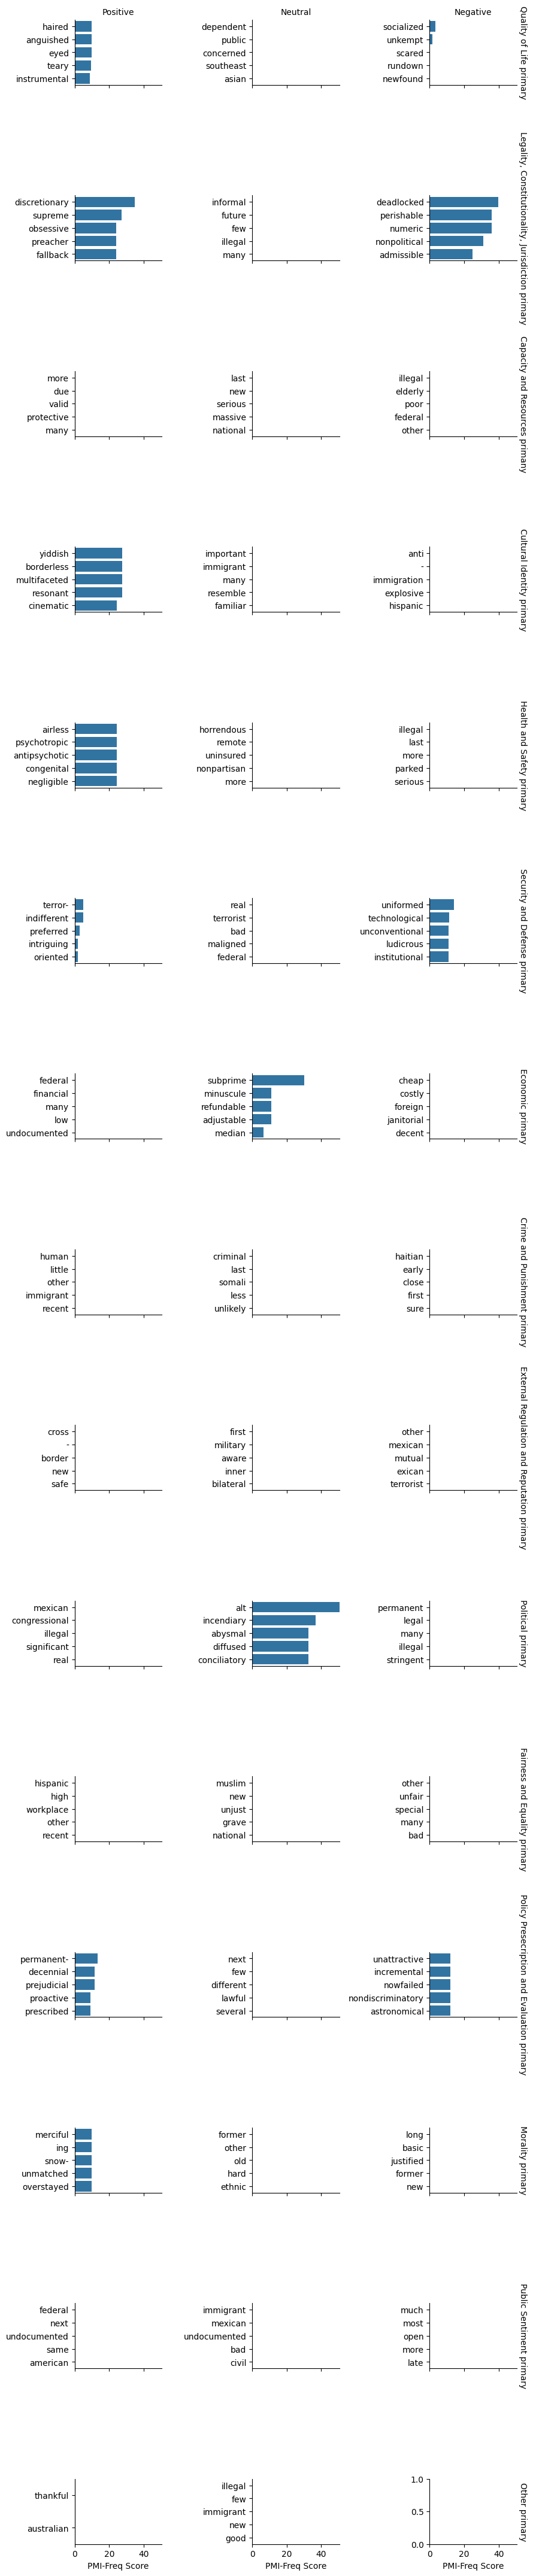

In [288]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the number of top words to display and create a new column for sorting
N = 5
df["Top N"] = df.groupby(["Frame", "Tone"])["PMI-Freq Score"].rank(
    method="first", ascending=False
)
top_n_df = df[df["Top N"] <= N]

# Define the figure size to make sure each subplot is large enough to be readable
plt.figure(figsize=(15, 20))  # Adjust the figure size as needed

# Create a FacetGrid with adjusted size, sharing the x-axis across all tones for uniform comparison
g = sns.FacetGrid(
    top_n_df,
    col="Tone",
    row="Frame",
    margin_titles=True,
    sharex=True,
    sharey=False,
    height=3,
    aspect=1,
)
g.map_dataframe(sns.barplot, y="Word", x="PMI-Freq Score", orient="h", legend=False)

# Set the same x-axis limit for all the subplots for better comparison
max_score = top_n_df["PMI-Freq Score"].max()
g.set(xlim=(0, max_score))

# Rotate the x-tick labels for better legibility and set the titles
g.set_axis_labels("PMI-Freq Score", "")
g.set_titles(col_template="{col_name}", row_template="{row_name}")

# Adjust the layout and add space to the top so the titles fit well
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)  # Adjust top spacing to fit frame titles

# Show plot
plt.show()